In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as t
from torch.utils.data import DataLoader

from torchsummary import summary

import copy

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformations = t.Compose([t.ToTensor(), t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
full = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transformations)

Files already downloaded and verified


In [5]:
full.data.shape

(50000, 32, 32, 3)

In [6]:
full_set, small_set = torch.utils.data.random_split(full, [0.96, 0.04])

In [7]:
train_set, test_set = torch.utils.data.random_split(full_set, [0.6, 0.4])

In [8]:
label_categories = full.classes

In [9]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [10]:
def ae_model():

    class AutoEncoder(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(3, 16, 4, 2, 1),
                nn.LeakyReLU(),
                nn.Conv2d(16, 32, 4, 2, 1),
                nn.LeakyReLU()
            )

            self.latent = nn.Sequential(
                nn.Conv2d(32, 64, 4, 2, 1),
                nn.ReLU()
            )

            self.dec = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 4, 2, 1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(32, 16, 4, 2, 1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16, 3, 4, 2, 1),
                nn.LeakyReLU()
            )

        def forward(self, x):
            return self.dec(self.latent(self.enc(x)))
    
    autoencoder = AutoEncoder()

    loss_fun = nn.MSELoss()

    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    return autoencoder, loss_fun, optimizer

In [11]:
summary(ae_model()[0], (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
         LeakyReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,832
              ReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 32, 8, 8]          32,800
         LeakyReLU-8             [-1, 32, 8, 8]               0
   ConvTranspose2d-9           [-1, 16, 16, 16]           8,208
        LeakyReLU-10           [-1, 16, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             771
        LeakyReLU-12            [-1, 3, 32, 32]               0
Total params: 83,619
Trainable params: 83,619
Non-trainable params: 0
---------------------------------

In [12]:
def ae_train_model():

    num_epochs = 30

    autoencoder, loss_fun, optimizer = ae_model()
    autoencoder.to(device)

    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):

        autoencoder.train()
        batch_loss = []

        for x, y in train_loader:
            x = x.to(device)

            y_hat = autoencoder(x)
            loss = loss_fun(y_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        train_loss.append(np.mean(batch_loss))

        autoencoder.eval()

        x, y = next(iter(test_loader))
        x = x.to(device)

        with torch.no_grad():
            y_hat = autoencoder(x)
            loss = loss_fun(y_hat, x)

        test_loss.append(loss.item())

    del x, y, y_hat, loss
    torch.cuda.empty_cache()

    return train_loss, test_loss, autoencoder

In [13]:
train_loss, test_loss, autoencoder = ae_train_model()

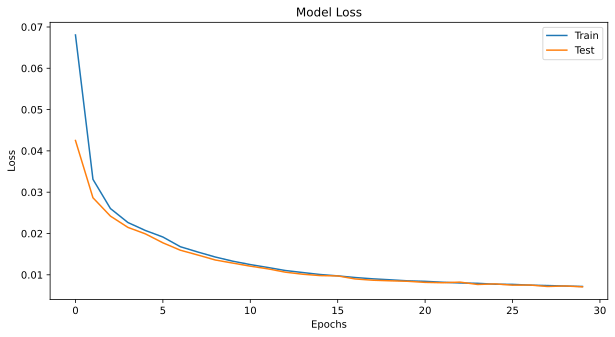

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, "-", label="Train")
plt.plot(test_loss, "-", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend();

In [15]:
def cnn_model():

    class CNN(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc_conv1 = nn.Conv2d(3, 16, 3, 2, 1)
            # (32 + 2*1 - 3)/2 + 1 = 16

            self.enc_conv2 = nn.Conv2d(16, 32, 3, 2, 1)
            # (16 + 2*1 - 3)/2 + 1 = 8

            self.fc1 = nn.Linear(8*8*32, 50)

            self.fc2 = nn.Linear(50, 10)

        def forward(self, x):
            x = self.enc_conv1(x)
            x = f.leaky_relu(x)

            x = self.enc_conv2(x)
            x = f.leaky_relu(x)

            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))

            x = self.fc1(x)
            x = f.leaky_relu(x)

            x = self.fc2(x)
            x = f.leaky_relu(x)

            return x

    cnn = CNN()

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

    return cnn, loss_fun, optimizer

In [16]:
summary(cnn_model()[0], (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
            Conv2d-2             [-1, 32, 8, 8]           4,640
            Linear-3                   [-1, 50]         102,450
            Linear-4                   [-1, 10]             510
Total params: 108,048
Trainable params: 108,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.41
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


In [17]:
def cnn_train_model(cnn, loss_fun, optimizer):

    num_epochs = 30

    cnn.to(device)

    train_loss = []
    train_acc = []
    dev_loss = []
    dev_acc = []

    for epoch in range(num_epochs):

        cnn.train()
        batch_loss = []
        batch_acc = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        cnn.eval()

        x, y = next(iter(test_loader))

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

        dev_loss.append(loss.item())
        dev_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

    del x, y, y_hat, loss
    torch.cuda.empty_cache()

    return train_acc, train_loss, dev_acc, dev_loss, cnn

In [18]:
cnn, loss_fun, optimizer = cnn_model()
train_acc, train_loss, test_acc, test_loss, cnn = cnn_train_model(cnn, loss_fun, optimizer)

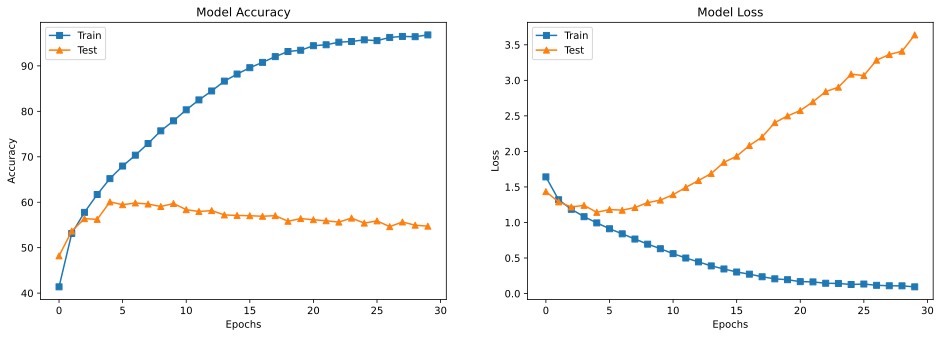

In [19]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "s-", label="Train")
axis[0].plot(test_acc, "^-", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].set_title("Model Accuracy")
axis[0].legend()

axis[1].plot(train_loss, "s-", label="Train")
axis[1].plot(test_loss, "^-", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Model Loss")
axis[1].legend();

In [20]:
pre_trained_model, loss_fun, optimizer = cnn_model()

for target, source in zip(pre_trained_model.named_parameters(), autoencoder.named_parameters()):
    if "enc" in target[0]:
        print(f"Pretrain: {target[0]} <-- AutoEnc: {source[0]}")
        target[1].data = copy.deepcopy(source[1].data)

Pretrain: enc_conv1.weight <-- AutoEnc: enc.0.weight
Pretrain: enc_conv1.bias <-- AutoEnc: enc.0.bias
Pretrain: enc_conv2.weight <-- AutoEnc: enc.2.weight
Pretrain: enc_conv2.bias <-- AutoEnc: enc.2.bias


In [21]:
train_acc, train_loss, test_acc, test_loss, post_cnn = cnn_train_model(pre_trained_model, loss_fun, optimizer)

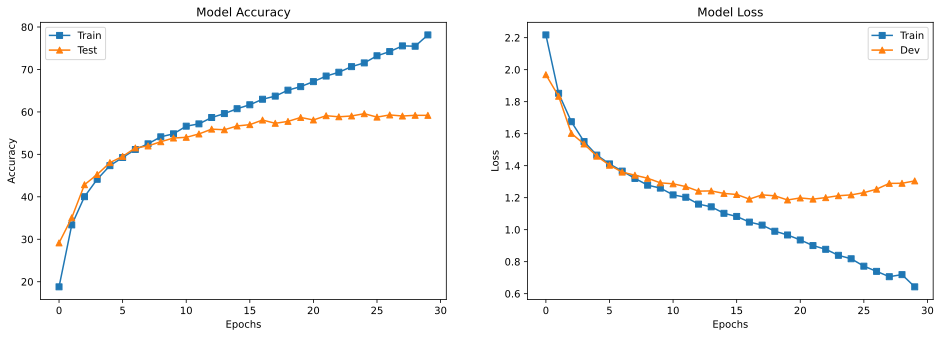

In [22]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "s-", label="Train")
axis[0].plot(test_acc, "^-", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].set_title("Model Accuracy")
axis[0].legend()

axis[1].plot(train_loss, "s-", label="Train")
axis[1].plot(test_loss, "^-", label="Dev")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Model Loss")
axis[1].legend();